In [9]:
import os
import numpy as np 
from glob import glob
from PIL import Image
import cv2
import matplotlib.pyplot as plt 
import slideio
import math

In [3]:
slide='../../data/CODIPAI-STOP-SS-00002-S-TP-01 (1).ndpi'
image_path='../../data/CODIPAI-STOP-SS-00002-S-TP-01.tiff'
mask='../../data/CODIPAI-STOP-SS-00002-S-TP-01_mask.tiff'
slide = slideio.open_slide(slide)
def size_ratio(scene,img_size):
    width = scene.rect[2]
    height = scene.rect[3]
    ratio=0
    inverse_ratio=0
    img_width=0
    img_height=0
    if width>height:
        ratio=img_size/width
        inverse_ratio=width/img_size
        img_width=img_size
        img_height=height*ratio
    else:
        ratio=img_size/height
        inverse_ratio=height/img_size
        img_height=img_size
        img_width=width*ratio
        
    return int(img_width),int(img_height),inverse_ratio

In [4]:
num_scenes = slide.num_scenes
scene = slide.get_scene(0)
img_width,img_height,ratio=size_ratio(scene,2048)
svsWidth = scene.rect[2]
svsHeight = scene.rect[3]
slide_block = scene.read_block((0, 0, svsWidth, svsHeight),size=(int(img_width), int(img_height)))
image=cv2.cvtColor(slide_block, cv2.COLOR_BGR2RGB)
cv2.imwrite(image_path, image)

True

True

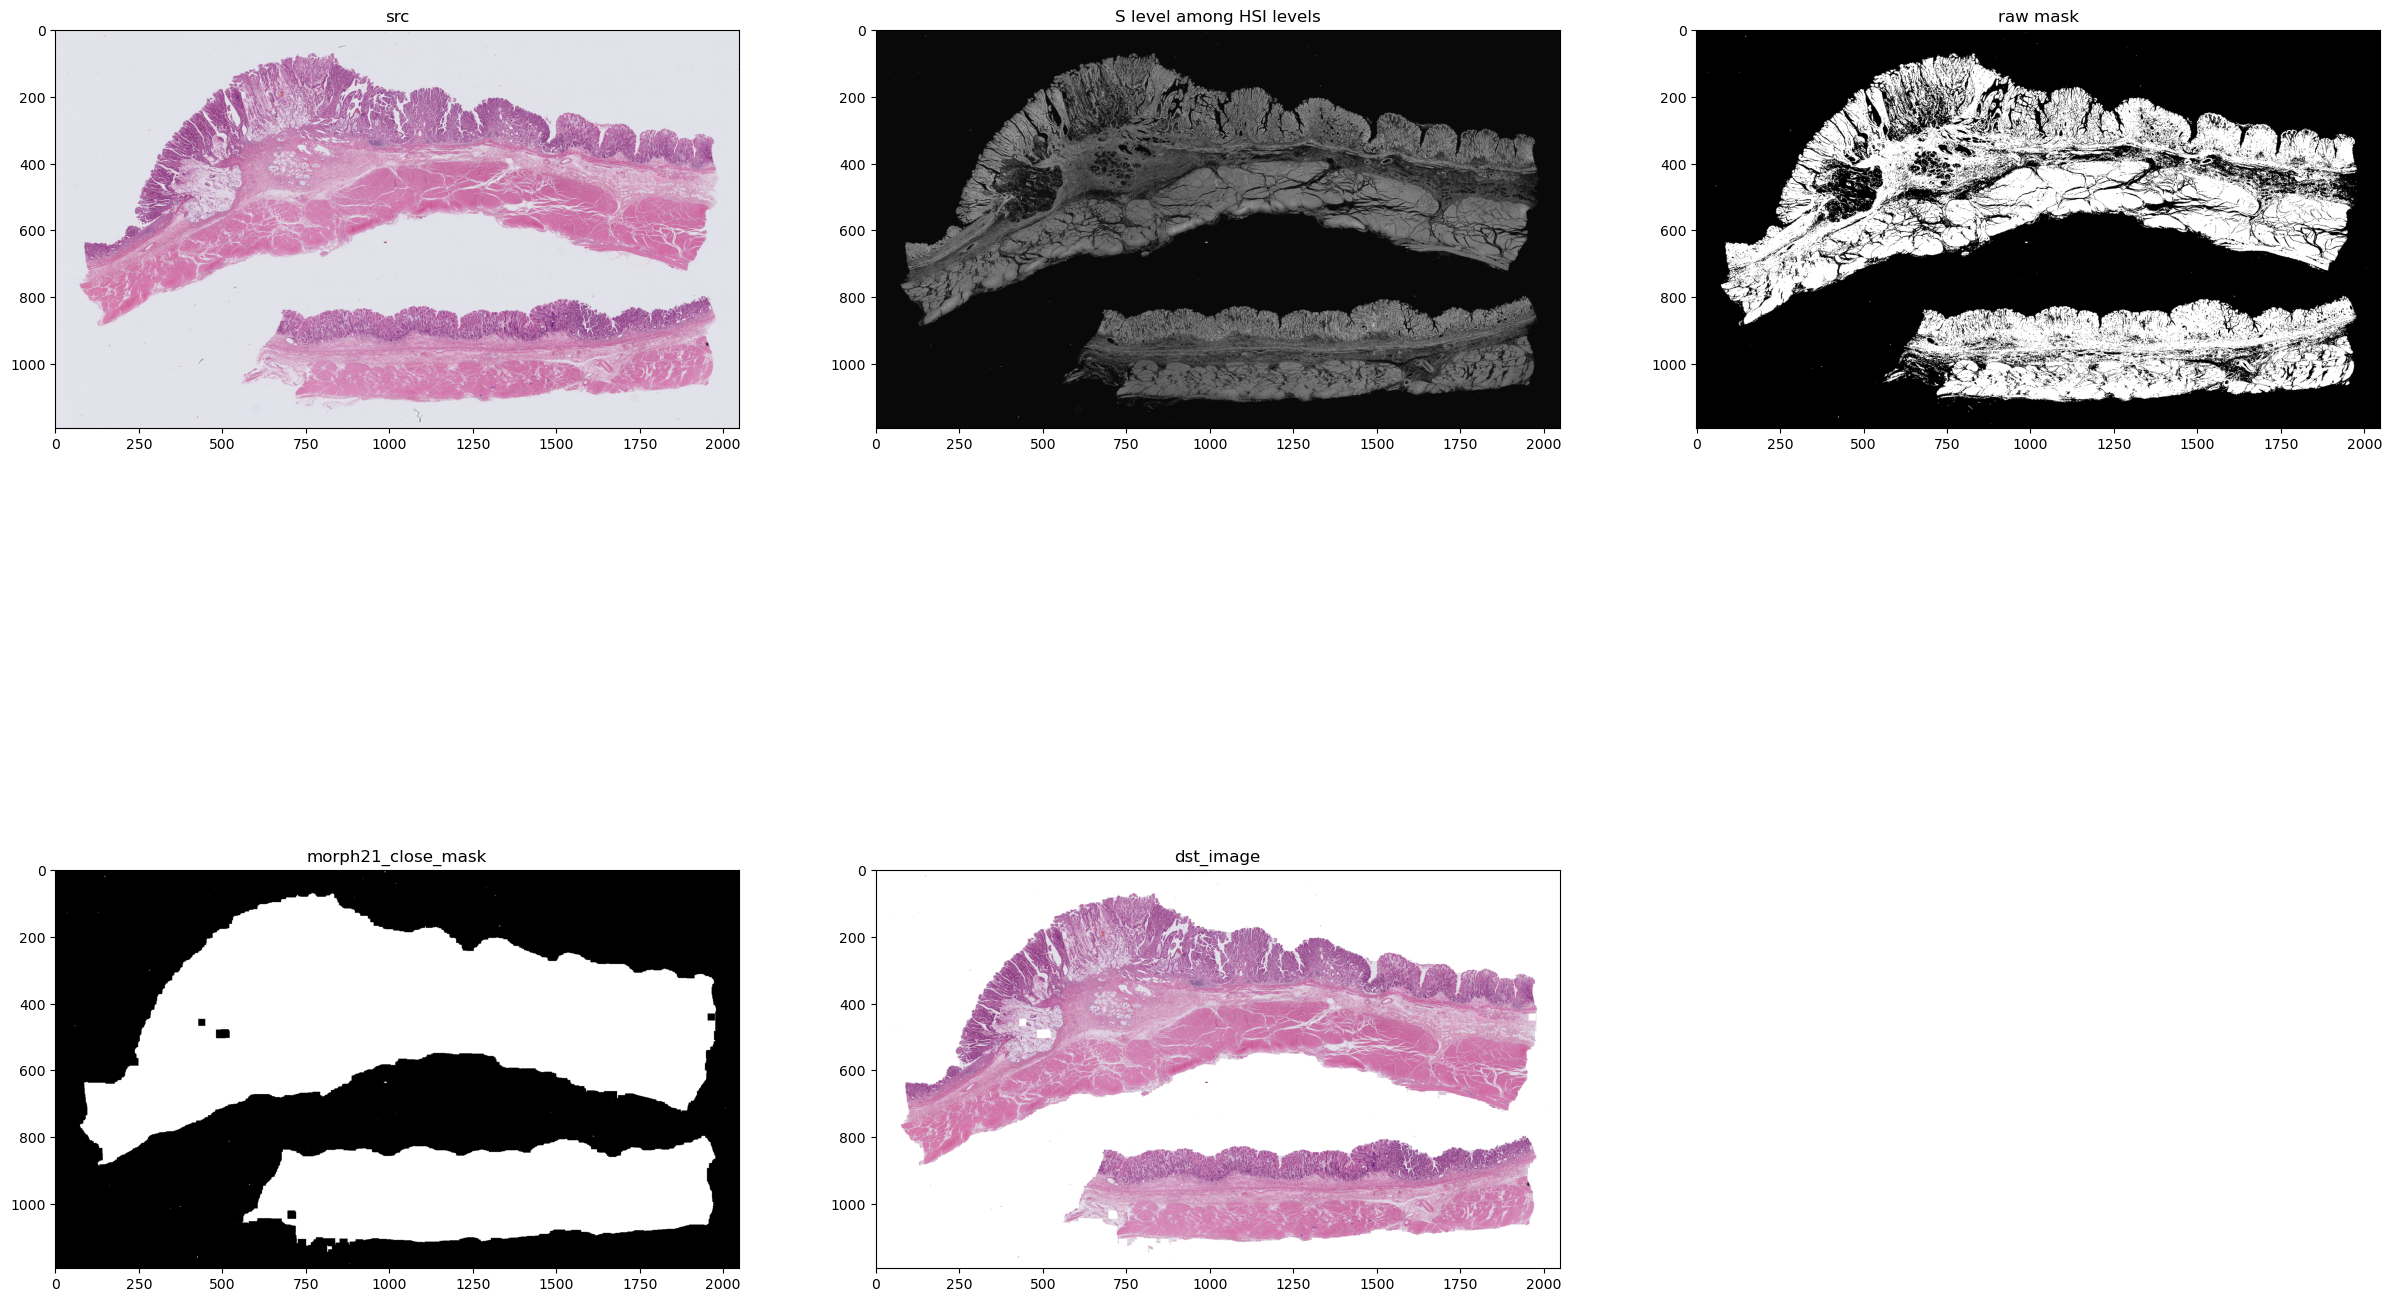

In [5]:
src_img=Image.open(image_path)
src_array_img=np.array(src_img)
HSI_src_array_img=cv2.cvtColor(src_array_img, cv2.COLOR_RGB2HSV)
ret, binary_array_img = cv2.threshold(HSI_src_array_img[:,:,1],127,255, cv2.THRESH_OTSU)
k = cv2.getStructuringElement(cv2.MORPH_RECT, (21,21))
morph_array_image= cv2.morphologyEx(binary_array_img, cv2.MORPH_CLOSE, k)

dst_image=np.zeros((morph_array_image.shape[0],morph_array_image.shape[1],3))
zero_point=np.where(morph_array_image==0)
dst_image[zero_point]=(255,255,255)
dst_image=np.where(dst_image==(0,0,0),src_array_img,(255,255,255))
fig = plt.figure(figsize=(30,20))
rows = 2
cols = 3
ax1 = fig.add_subplot(rows, cols, 1)
ax1.imshow(src_array_img)
ax1.set_title('src')
 
ax2 = fig.add_subplot(rows, cols, 2)
ax2.imshow(HSI_src_array_img[:,:,1],'gray')
ax2.set_title('S level among HSI levels')

ax2 = fig.add_subplot(rows, cols, 3)
ax2.imshow(binary_array_img,'gray')
ax2.set_title('raw mask')

ax2 = fig.add_subplot(rows, cols, 4)
ax2.imshow(morph_array_image,'gray')
ax2.set_title('morph21_close_mask')

ax2 = fig.add_subplot(rows, cols, 5)
ax2.imshow(dst_image)
ax2.set_title('dst_image')
cv2.imwrite(mask,morph_array_image)

In [13]:
slide_tile_size=1024

count=0
scene = slide.get_scene(0)
svsWidth = scene.rect[2]
svsHeight = scene.rect[3]
mask_image=np.array(Image.open(mask))
ratio=svsWidth/img_width
inverse_ratio=math.floor(1/ratio*10000)/10000
for widthCount in range(0, int(svsWidth // slide_tile_size)):
    for heightCount in range(0, int(svsHeight // slide_tile_size)):
        point_x =np.linspace(widthCount*slide_tile_size,widthCount*slide_tile_size+slide_tile_size-1,slide_tile_size,dtype=np.int32)
        point_y =np.linspace(heightCount*slide_tile_size,heightCount*slide_tile_size+slide_tile_size-1,slide_tile_size,dtype=np.int32)
        point=np.meshgrid(point_x,point_y)
        mask_point=np.copy(point)
        mask_point[0]=(mask_point[0]*inverse_ratio).astype(np.int64)
        mask_point[1]=(mask_point[1]*inverse_ratio).astype(np.int64)
        if mask_point[0].max()==mask_image.shape[1]:
            mask_point[0]-=1
        if mask_point[1].max()==mask_image.shape[0]:
            mask_point[1]-=1
        try:
            tile_mask_image=mask_image[mask_point[1],mask_point[0]]/255
            if tile_mask_image.mean()>=1/2:
                count+=1
                image = scene.read_block((widthCount * slide_tile_size, heightCount * slide_tile_size, slide_tile_size, slide_tile_size),size=(1024,1024))
                img=Image.fromarray(image).resize((1024,1024))
                
                img.save('../../data/ww_tiling/512/'+str(widthCount * slide_tile_size)+'_'+str(heightCount * slide_tile_size)+'.jpg')
                img_count=0
                k=np.random.randint(2, size=1)[0]
                j=np.random.randint(2, size=1)[0]
                img=image[512*k:512*k+512,512*j:512*j+512]
                while_count=0
                while len(np.where(img[:,:,1]>=200)[0]) < (512*512)/2:
                    k=np.random.randint(2, size=1)[0]
                    j=np.random.randint(2, size=1)[0]
                    img=image[512*k:512*k+512,512*j:512*j+512]
                    while_count+=1
                    if while_count==10:
                        break
                Image.fromarray(img).resize((256,256)).save(validation_tile_path+data_frame.loc[0]['폴더']+'/10x/'+fileName+'/'+fileName+'_'+str(count)+'.jpg')
                k=np.random.randint(4, size=1)[0]
                j=np.random.randint(4, size=1)[0]
                img=image[256*k:256*k+256,256*j:256*j+256]
                while_count=0
                while len(np.where(img[:,:,1]>=200)[0]) < (256*256)/2:
                    k=np.random.randint(2, size=1)[0]
                    j=np.random.randint(2, size=1)[0]
                    img=image[256*k:256*k+256,256*j:256*j+256]
                    while_count+=1
                    if while_count==10:
                        break
                Image.fromarray(img).resize((256,256)).save(validation_tile_path+data_frame.loc[0]['폴더']+'/20x/'+fileName+'/'+fileName+'_'+str(count)+'.jpg')
                img_count+=1

KeyboardInterrupt: 

In [12]:
mask_point[0]

array([[451, 451, 451, ..., 466, 466, 466],
       [451, 451, 451, ..., 466, 466, 466],
       [451, 451, 451, ..., 466, 466, 466],
       ...,
       [451, 451, 451, ..., 466, 466, 466],
       [451, 451, 451, ..., 466, 466, 466],
       [451, 451, 451, ..., 466, 466, 466]], dtype=int32)